# Train the model

In [1]:
import datetime

# Training Parameters
epochs = 10
learning_rate = 0.001

# Dataset Parameters
dataset_daily_frequency = 24 # 24 corresponds to hourly data
target_col_name = "FCR_N_PriceEUR"
timestamp_col = "timestamp"
cutoff_date = datetime.datetime(2017, 1, 1)

# Scheduled Sampling Parameters
x_mid = round(epochs * 0.55) # shift=0.5 converges f(midpoint) = 0.5; shifts scheduled_sampling_ratio curve further/closer from end of dataset
start_scheduled_sampling_epoch = round(epochs * 0.2) # Adjust this value to start scheduled sampling after a certain epoch
k = 0.3

# Model Parameters
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 2 * dataset_daily_frequency
enc_seq_len = 7 * dataset_daily_frequency # supposing you want the model to base its forecasts on the previous 5 days of data
output_sequence_length = 2 * dataset_daily_frequency # target sequence length. If hourly data and length = 48, you predict 2 days ahead
step_size = 1
batch_first = False
num_predicted_features = 1

# Hyperparameters
test_size = 0.15
validation_size = 0.15
forecast_window = 2 * dataset_daily_frequency # supposing you're forecasting 48 hours ahead
batch_size = 1 * forecast_window # 128
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences

# Define input variables
exogenous_vars = []
input_variables = [target_col_name] + exogenous_vars
input_size = len(input_variables)

In [2]:
# Define the scheduled sampling function (Sigmoid decay curve)
def sigmoid_decay(x, x_mid, x_max, start_scheduled_sampling_epoch):
    # Sigmoid function with scaling and shifting
    return 1 / (1 + np.exp(-(x - start_scheduled_sampling_epoch - x_mid) / (k * (x_max - x_mid))))

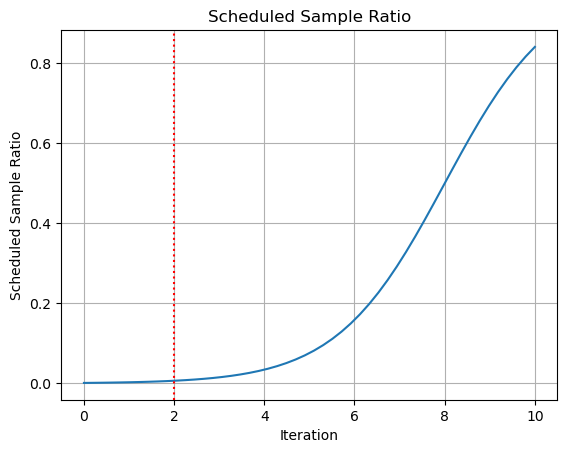

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x_values = np.linspace(0, epochs)

# Calculate y values using the sigmoid decay function
y_values = sigmoid_decay(x_values, x_mid, epochs, start_scheduled_sampling_epoch)

# Plot the curve
plt.plot(x_values, y_values)
plt.xlabel('Iteration')
plt.ylabel('Scheduled Sample Ratio')
plt.title('Scheduled Sample Ratio')
plt.grid(True)
plt.axvline(x=start_scheduled_sampling_epoch, color='red', linestyle='dotted')
plt.show()

In [4]:
import utils
import dataset as ds
import torch
from torch.utils.data import DataLoader

# Read data
data = utils.read_data('dfs_merged_upload')

# Split data into training, validation, and test sets
train_split_idx = round(len(data) * (1 - test_size - validation_size))
validation_split_idx = round(len(data) * (1 - test_size))
training_data_raw = data[:train_split_idx]
validation_data_raw = data[train_split_idx:validation_split_idx]
test_data_raw = data[validation_split_idx:]

# Get training indices
training_indices = utils.get_indices_entire_sequence(
    data=training_data_raw,
    window_size=window_size,
    step_size=step_size)

# Get validation indices
validation_indices = utils.get_indices_entire_sequence(
    data=validation_data_raw,
    window_size=window_size,
    step_size=step_size)

# Get test indices
test_indices = utils.get_indices_entire_sequence(
    data=test_data_raw,
    window_size=window_size,
    step_size=step_size)

# Create custom dataset class for training data
training_data = ds.TransformerDataset(
    data=torch.tensor(training_data_raw[input_variables].values).float(),
    indices=training_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length)

# Create custom dataset class for validation data
validation_data = ds.TransformerDataset(
    data=torch.tensor(validation_data_raw[input_variables].values).float(),
    indices=validation_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length)

# Create custom dataset class for test data
test_data = ds.TransformerDataset(
    data=torch.tensor(test_data_raw[input_variables].values).float(),
    indices=test_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length)

# Create DataLoader for training data
training_dataloader = DataLoader(training_data, batch_size)

# Create DataLoader for validation data
validation_dataloader = DataLoader(validation_data, batch_size)

# Create DataLoader for test data
test_dataloader = DataLoader(test_data, batch_size)

Reading file in data/dfs_merged_upload.csv
From get_src_trg: data size = torch.Size([32189, 1])
From get_src_trg: data size = torch.Size([6898, 1])
From get_src_trg: data size = torch.Size([6898, 1])


In [5]:
import transformer_timeseries as tst

# Initialize model
model = tst.TimeSeriesTransformer(
    input_size=input_size,
    dec_seq_len=dec_seq_len,
    batch_first=batch_first,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val
)

In [6]:
def train_model(model, training_dataloader, optimizer, loss_function, scheduled_sampling_ratio):
    model.train()
    loss_history = []

    for i, batch in enumerate(training_dataloader):
        src, trg, trg_y = batch

        # Scheduled sampling
        if scheduled_sampling_ratio > np.random.rand():
            trg = trg_y.unsqueeze(-num_predicted_features)  # Add a singleton dimension for the features

        # Permute shape if needed
        if not batch_first:
            src = src.permute(1, 0, 2)
            trg = trg.permute(1, 0, 2)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate masks
        trg_mask = utils.generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=forecast_window,
            device=device
        )
        src_mask = utils.generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=enc_seq_len,
            device=device
        )

        # Make forecasts
        prediction = model(src, trg, src_mask, trg_mask)

        # Compute loss
        loss = loss_function(trg_y, prediction)

        # Backward pass
        loss.backward()

        # Take optimizer step
        optimizer.step()

        # Append to training loss history
        loss_history.append(loss.item())

        print(f"Epoch: {epoch}/{epochs}, Batch: {i}/{len(training_dataloader)}, Loss: {loss.item()} Scheduled Sampling Ratio: {scheduled_sampling_ratio}")
        
    return loss_history

In [7]:
"""
Put model in evaluation mode, calculate average loss across validation dataset.
"""
def validate_model(device, model, validation_dataloader, loss_function):
        model.eval()
        
        loss_history = []

        with torch.no_grad():
            for i, (src, _, trg_y) in enumerate(validation_dataloader):

                prediction = inference.run_encoder_decoder_inference(
                    model=model, 
                    src=src, 
                    forecast_window=forecast_window,
                    batch_size=src.shape[1],
                    device=device
                )
                
                trg_y = trg_y.permute(1, 0).unsqueeze(-1)  # Shape becomes [48, 256, 1]

                print(f"Shape of prediction: {prediction.shape}")
                print(f"Shape of target: {trg_y.shape}")
                print(f"Shape of src: {src.shape}")


                loss = loss_function(trg_y, prediction)
                loss_history.append(loss.item())

        return loss_history

In [8]:
"""
Demonstrating how to use the transformer model with time-series data.
This code includes a full training loop with scheduled sampling and an evaluation step.
"""

import numpy as np
import inference
from accelerate import Accelerator
import time

# Define loss function and optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
training_loss_history = []
validation_loss_history = []

# Prepare device
accelerator = Accelerator()
device = accelerator.device
model, optimizer, training_dataloader = accelerator.prepare(
    model,
    optimizer,
    training_dataloader,
)
model.to(device)

# Training loop
training_loss_history = []
validation_loss_history = []
for epoch in range(epochs):
    start_time = time.time()

    # Scheduled Sampling
    if epoch >= start_scheduled_sampling_epoch:
        scheduled_sampling_ratio = sigmoid_decay(epoch, x_mid, epochs, start_scheduled_sampling_epoch)
    else:
        scheduled_sampling_ratio = 0.0  # Use teacher-forcing before start_scheduled_sampling_epoch
    
    # Training Phase    
    training_loss_history = train_model(model, training_dataloader, optimizer, loss_function, scheduled_sampling_ratio)
      
    # Validation phase  
    validation_loss_history = validate_model(device, model, validation_dataloader, loss_function)
    
    end_time = time.time()
    print(f"Epoch: {epoch}, Average Training Loss: {sum(training_loss_history) / len(training_loss_history)} Average Validation Loss: {sum(validation_loss_history) / len(validation_loss_history)} Time (s): {end_time - start_time}")

/Users/ryneschroder/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([48, 48, 1])) that is different to the input size (torch.Size([48, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0/10, Batch: 0/667, Loss: 827.7965698242188 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 1/667, Loss: 360.9610900878906 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 2/667, Loss: 240.1166534423828 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 3/667, Loss: 271.6027526855469 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 4/667, Loss: 210.41636657714844 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 5/667, Loss: 167.38111877441406 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 6/667, Loss: 163.34725952148438 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 7/667, Loss: 101.90404510498047 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 8/667, Loss: 79.00782775878906 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 9/667, Loss: 89.78211212158203 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 10/667, Loss: 79.25994873046875 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 11/667, Loss: 66.14630126953125 Scheduled Sampling Ratio: 0.0
Epoch: 0/10, Batch: 12

/Users/ryneschroder/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([48, 5, 1])) that is different to the input size (torch.Size([5, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0/10, Batch: 666/667, Loss: 1.4145771265029907 Scheduled Sampling Ratio: 0.0
Shape of prediction: torch.Size([48, 168, 1])
Shape of target: torch.Size([48, 48, 1])
Shape of src: torch.Size([48, 168, 1])


/Users/ryneschroder/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([48, 168, 1])) that is different to the input size (torch.Size([48, 48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (48) must match the size of tensor b (168) at non-singleton dimension 1

In [ ]:
import matplotlib.pyplot as plt

# view training
training_loss_history = np.array(training_loss_history).reshape(-1)
x = range(training_loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, training_loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

# Evaluate the model

In [ ]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts_[0].shape

In [ ]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_data):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])
    
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")